In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# Use autoload_with instead of reflect when calling prepare
Base.prepare(engine, reflect=True)

C:\Users\Jackie\AppData\Local\Temp\ipykernel_13104\1931925234.py:5: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [9]:
# Query Measurement table and print the first 5 rows
for row in session.query(measurement).limit(5).all():
    print(row.__dict__)

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x000001CD76D72920>, 'station': 'USC00519397', 'date': '2010-01-01', 'tobs': 65.0, 'prcp': 0.08, 'id': 1}
{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x000001CD76D72560>, 'station': 'USC00519397', 'date': '2010-01-02', 'tobs': 63.0, 'prcp': 0.0, 'id': 2}
{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x000001CD76D728C0>, 'station': 'USC00519397', 'date': '2010-01-03', 'tobs': 74.0, 'prcp': 0.0, 'id': 3}
{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x000001CD76D72500>, 'station': 'USC00519397', 'date': '2010-01-04', 'tobs': 76.0, 'prcp': 0.0, 'id': 4}
{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x000001CD76D73520>, 'station': 'USC00519397', 'date': '2010-01-06', 'tobs': 73.0, 'prcp': None, 'id': 5}


# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
latest_date = session.query(measurement.date).order_by(measurement.date.desc()).first()

print(f"The most recent date in the dataset is: {latest_date[0]}")


The most recent date in the dataset is: 2017-08-23


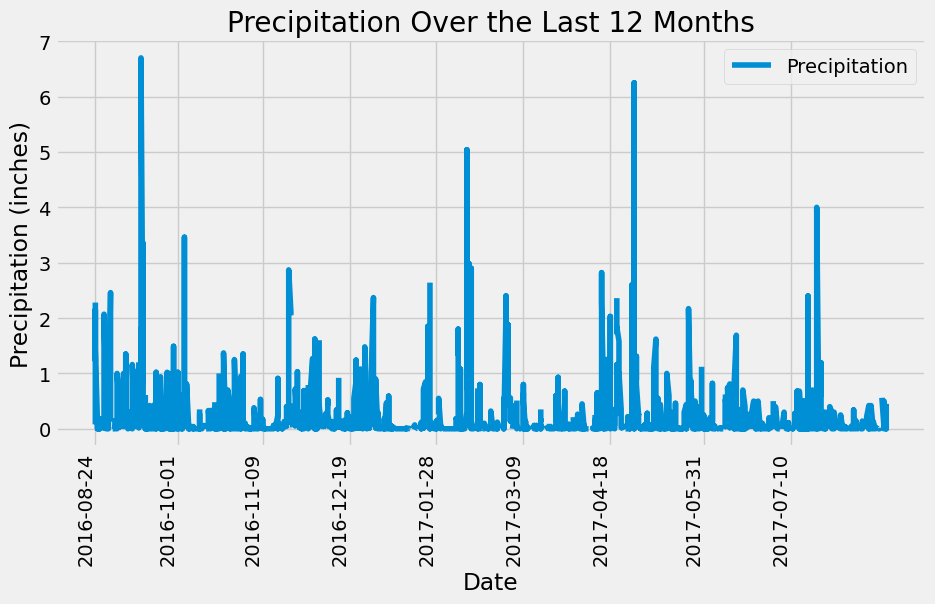

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
latest_date = session.query(measurement.date).order_by(measurement.date.desc()).first()[0]
latest_date = dt.datetime.strptime(latest_date, '%Y-%m-%d')
one_year_ago = latest_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date >= one_year_ago).\
    order_by(measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values('Date')

# Convert 'Date' column to datetime format
precipitation_df['Date'] = pd.to_datetime(precipitation_df['Date'])

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(x='Date', y='Precipitation', figsize=(10, 6), title='Precipitation Over the Last 12 Months')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')

# Get the specific dates you want to show on the x-axis
specific_dates = ['2016-08-24', '2016-10-01', '2016-11-09', '2016-12-19', '2017-01-28', '2017-03-09', '2017-04-18', '2017-05-31', '2017-07-10']

# Convert specific dates to datetime format
specific_dates = pd.to_datetime(specific_dates)

# Set x-axis tick positions and labels
plt.xticks(specific_dates, rotation=90)

plt.show()

In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = precipitation_df.describe()

summary_statistics

,Date,Precipitation
count,2223,2015.000000
mean,2017-02-16 18:54:53.927125248,0.176462
min,2016-08-24 00:00:00,0.000000
25%,2016-11-19 00:00:00,0.000000
50%,2017-02-15 00:00:00,0.020000
75%,2017-05-17 00:00:00,0.130000
max,2017-08-23 00:00:00,6.700000
std,NaN,0.460288


# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(station.station)).scalar()

print(f'Total number of stations in the dataset: {total_stations}')


Total number of stations in the dataset: 9


In [17]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

most_active_stations = session.query(measurement.station, func.count(measurement.station)).\
    group_by(measurement.station).\
    order_by(func.count(measurement.station).desc()).all()

# Display the result
print("Most Active Stations:")
for station, count in most_active_stations:
    print(f"Station ID: {station}, Count: {count}")
    
# Print the station with the greatest number of observations, or nothing if there is no data
most_active_station = next(iter(most_active_stations), (None,))[0]
if most_active_station is not None:
    print(f"\nThe station with the greatest number of observations is Station ID: {most_active_station}")


Most Active Stations:
Station ID: USC00519281, Count: 2772
Station ID: USC00519397, Count: 2724
Station ID: USC00513117, Count: 2709
Station ID: USC00519523, Count: 2669
Station ID: USC00516128, Count: 2612
Station ID: USC00514830, Count: 2202
Station ID: USC00511918, Count: 1979
Station ID: USC00517948, Count: 1372
Station ID: USC00518838, Count: 511

The station with the greatest number of observations is Station ID: USC00519281


In [18]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = most_active_stations[0][0]

# Design a query to calculate the lowest, highest, and average temperature for the most active station
temperature_stats = session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)).\
    filter(measurement.station == most_active_station).all()

# Display the result
lowest_temp, highest_temp, avg_temp = temperature_stats[0]

print(f"Temperature Statistics for Most Active Station (Station ID: {most_active_station}):")
print(f"Lowest Temperature: {lowest_temp}°F")
print(f"Highest Temperature: {highest_temp}°F")
print(f"Average Temperature: {round(avg_temp, 2)}°F")


Temperature Statistics for Most Active Station (Station ID: USC00519281):
Lowest Temperature: 54.0°F
Highest Temperature: 85.0°F
Average Temperature: 71.66°F


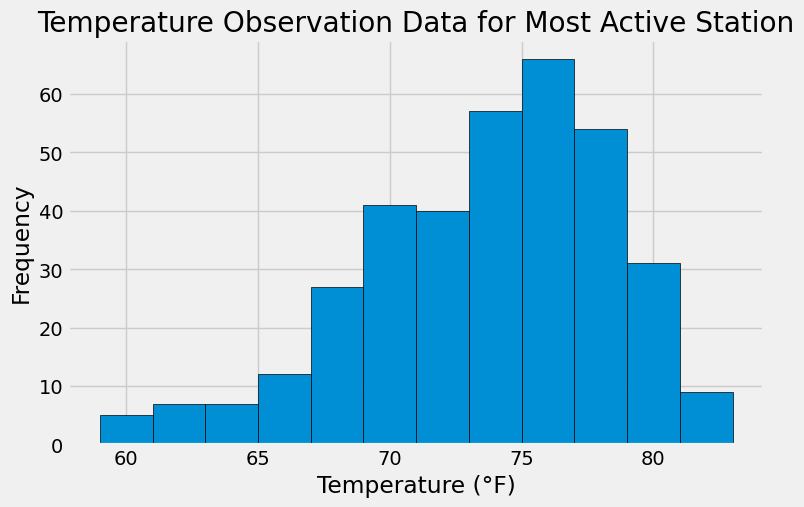

In [21]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
latest_date_for_most_active_station = session.query(measurement.date).\
    filter(measurement.station == most_active_station).\
    order_by(measurement.date.desc()).first()[0]
latest_date_for_most_active_station = dt.datetime.strptime(latest_date_for_most_active_station, '%Y-%m-%d')
one_year_ago_for_most_active_station = latest_date_for_most_active_station - dt.timedelta(days=365)

# Query the last 12 months of temperature observation data for the most active station
temperature_data_most_active_station = session.query(measurement.tobs).\
    filter(measurement.station == most_active_station).\
    filter(measurement.date >= one_year_ago_for_most_active_station).all()

# Save the query results as a Pandas DataFrame
temperature_df_most_active_station = pd.DataFrame(temperature_data_most_active_station, columns=['Temperature'])

# Plot the results as a histogram
plt.figure(figsize=(8, 5))
plt.hist(temperature_df_most_active_station['Temperature'], bins=12, edgecolor='black')
plt.title('Temperature Observation Data for Most Active Station')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.show()


# Close Session

In [22]:
# Close Session
session.close()